In [1]:
import pandas as pd
df_full = pd.read_csv('final_df.csv')

In [2]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519977 entries, 0 to 519976
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    518920 non-null  object
 1   Result  519977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [3]:
df_full.head()

,Text,Result
0,forecast,0
1,traveling business meeting take fun trip espec...,0
2,test test successful way go,0
3,randy send schedule salary level everyone sche...,0
4,hello let shoot tuesday,0


In [4]:
df_full.isnull().sum()

Text      1057
Result       0
dtype: int64

In [5]:
df_full = df_full.dropna()

In [6]:
df_full.shape

(518920, 2)

# Data Splitting

In [7]:
print(df_full['Result'].value_counts())

0    516457
1      2463
Name: Result, dtype: int64


In [8]:
results = df_full['Result'].value_counts()
total = results.sum()

percentage_normal = (results[0] / total) * 100
percentage_spam = (results[1] / total) * 100

print(f'Percentage of Normal: {percentage_normal:.2f}%')
print(f'Percentage of Spam: {percentage_spam:.2f}%')


Percentage of Normal: 99.53%
Percentage of Spam: 0.47%


In [9]:
spam_df = df_full[df_full['Result'] == 1]

num_samples = len(spam_df) * 10
normal_df = df_full[df_full['Result'] == 0].sample(n=num_samples, random_state=1)

df = pd.concat([spam_df, normal_df])

# Shuffle the resulting DataFrame
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# Display the new partial DataFrame
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27093 entries, 0 to 27092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    27093 non-null  object
 1   Result  27093 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 423.5+ KB
None
                                                Text  Result
0  mimeversion task assignmentstatus completedtas...       0
1  mimeversion contenttype textplain charsetusasc...       0
2  metro downtown route change employee ride metr...       0
3  isda schedule enroneweb transaction fyi propos...       0
4  check election link electoral map page hoskins...       0


##  Resampling Dataset

In [10]:
results = df['Result'].value_counts()
total = results.sum()

percentage_normal = (results[0] / total) * 100
percentage_spam = (results[1] / total) * 100

print(f'Percentage of Normal: {percentage_normal:.2f}%')
print(f'Percentage of Spam: {percentage_spam:.2f}%')
print(df['Result'].value_counts())

Percentage of Normal: 90.91%
Percentage of Spam: 9.09%
0    24630
1     2463
Name: Result, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample

X = df['Text']
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features = 100)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Dummy Classifier

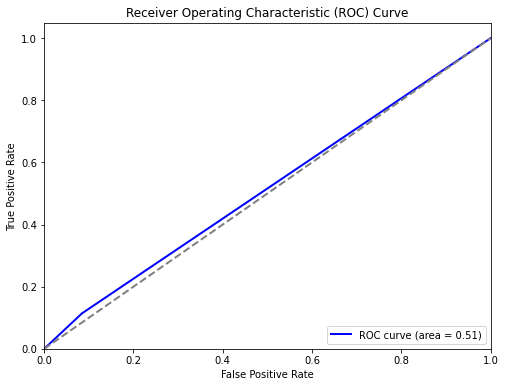

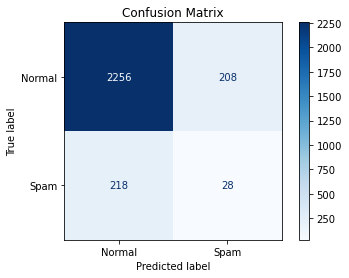

Accuracy: 0.8428
Precision: 0.1186
Recall: 0.1138


In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = dummy_clf.predict(X_test_tfidf)
y_pred_proba = dummy_clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Random Forest

## Grid Search

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 500}
Best estimator found:  RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       n_estimators=500, random_state=42)


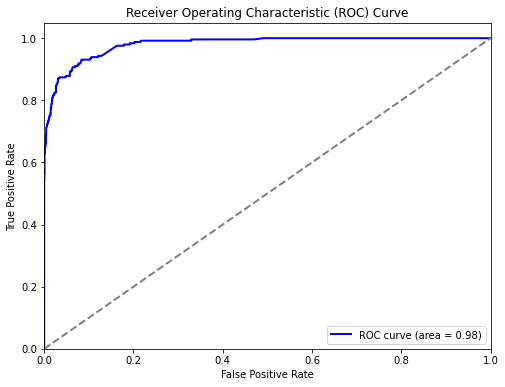

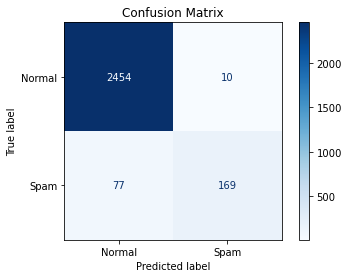

Accuracy: 0.9679
Precision: 0.9441
Recall: 0.6870
ROC AUC: 0.9803


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 50],
    'bootstrap': [True, False]
}


# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=5, verbose=2, n_jobs=-1)

# Fit Grid Search to the data
grid_search.fit(X_train_tfidf, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Display the best estimator
best_clf = grid_search.best_estimator_
print("Best estimator found: ", best_clf)

# Evaluate the best estimator on the test set
y_pred = best_clf.predict(X_test_tfidf)
y_pred_proba = best_clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

## Cross Validation

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Perform cross-validation on the training data with the best estimator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_clf, X_train_tfidf, y_train, cv=cv, scoring='roc_auc')

print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Mean cross-validation ROC AUC: {cv_scores.mean():.4f}')
print(f'Standard deviation of cross-validation ROC AUC: {cv_scores.std():.4f}')

Cross-validation ROC AUC scores: [0.98089257 0.98129914 0.97965149 0.97533199 0.97511278]
Mean cross-validation ROC AUC: 0.9785
Standard deviation of cross-validation ROC AUC: 0.0027


# Handle imbalanced data
## "class_weight" parameter for RandomForest classifier

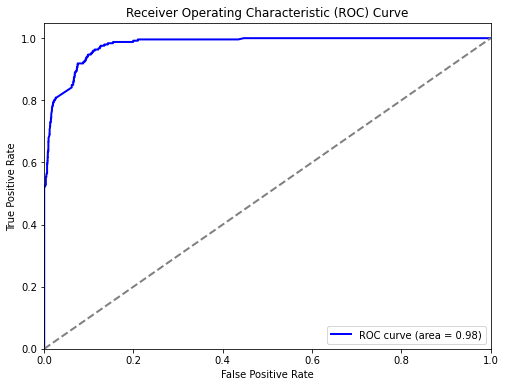

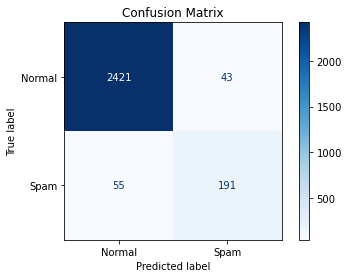

Accuracy: 0.9638
Precision: 0.8162
Recall: 0.7764


In [21]:
# Train the Random Forest classifier with class weights,
# the classes will be weighted inversely proportional to how frequently they appear in the data.
clf = RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',n_estimators=500, random_state=42,class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

## OverSampling

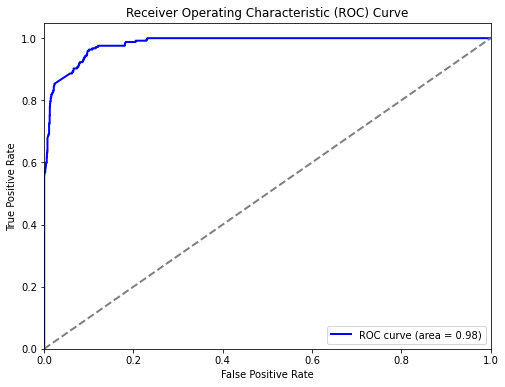

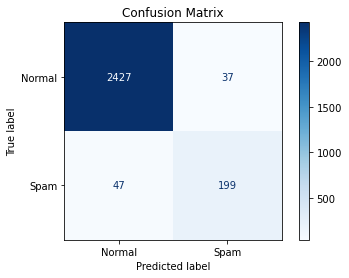

Accuracy: 0.9690
Precision: 0.8432
Recall: 0.8089


In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train the Random Forest classifier on the resampled dataset
clf = RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',n_estimators=500, random_state=42,class_weight='balanced')
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


# Embeddings

## Word2Vec

In [ ]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300') 

## Bag-of-Words